# Imports and initialization

In [1]:
import torch
from model_cond import VAE
import torchvision
from PIL import Image
import matplotlib.pyplot as plt
import clip
import torchvision.transforms as transforms
from tqdm import tqdm
from torchmetrics.image import TotalVariation
import os
import numpy as np

In [2]:
DEVICE = "cuda"

model = VAE().to(DEVICE)
model.load_state_dict(torch.load("train_results/model_weights_final.pth"))
to_tensor = torchvision.transforms.functional.to_tensor

dummy input shape  torch.Size([4096])


In [3]:
def plot_loss(loss):
    f,ax=plt.subplots(figsize=(5,3))
    plt.plot(loss['optim_loss'])
    plt.suptitle("Optimization loss");

In [4]:
def plot_image(img):
    img = img[0].permute(1,2,0).detach().cpu()
    height, width, depth = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width/64 , height/64
    fig, ax = plt.subplots(figsize=figsize)
    ax.imshow(img.numpy(), interpolation='nearest')

In [5]:
def plot_comparison(before, after):

    before = before[0].permute(1,2,0).detach().cpu()
    after  = after[0].permute(1,2,0).detach().cpu()

    f, axarr = plt.subplots(2)
    f.tight_layout()
    axarr[0].imshow(before)
    axarr[0].set_title("Before") 
    axarr[1].imshow(after)
    axarr[1].set_title("After") 

In [6]:
transform_normalize = transforms.Compose([
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])

In [84]:
def plot_image_batch(batch, title, labels):
    batch = batch.permute(0, 2, 3, 1).detach().cpu()
    
    num_rows, num_cols = 3, 3
    f, axarr = plt.subplots(num_rows, num_cols, figsize=(10, 6))
    plt.suptitle(title)
    
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            axarr[i, j].imshow(batch[index])
            axarr[i, j].axis('off')
            axarr[i, j].set_title(labels[index], fontsize=10)


In [87]:
def plot_loss_batch(losses, title, labels, key="optim_loss"):
    num_rows, num_cols = 3, 3
    f, axarr = plt.subplots(num_rows, num_cols, figsize=(10, 8))
    plt.suptitle(title)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            axarr[i, j].plot(losses[index][key])
            axarr[i, j].set_title(f'Image {index+1}')
            axarr[i, j].set_xlabel('Epoch')
            axarr[i, j].set_ylabel('Loss')
            axarr[i, j].set_title(labels[index],fontsize=10)
            axarr[i, j].tick_params(axis='both', labelsize=8)
            axarr[i, j].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
    plt.tight_layout()

# VAE Inference demo

For this homework project, I created a simple toy VAE with the PolyHaven dataset, which learns to reconstruct given samples of environment maps. Then, I will use the VAE to optimize on its latent code using the CLIP-based loss given a prompt. In addition to the traditional VAE losses, I added a CLIP-based loss using the fine-tuned model from clip_finetune.ipynb.
For the code of the VAE, the reference is at
- vae_model.py
- vae_train.py

Please note that the quality of the VAE may not be optimal, but the goal here is to experiment with the CLIP-based optimization

In [50]:
import random
random.seed(64)
img_names = os.listdir("dataset/polyhaven_png_128/")
images_filenames = random.sample(img_names, 9)

images_labels = [label[:-7] for label in images_filenames]


images_filenames

['harties_1k.png',
 'belfast_farmhouse_1k.png',
 'lot_02_1k.png',
 'lenong_2_1k.png',
 'flower_road_1k.png',
 'kloetzle_blei_1k.png',
 'rural_landscape_1k.png',
 'moulton_falls_train_tunnel_east_1k.png',
 'abandoned_hall_01_1k.png']

In [9]:
x_tensors = torch.from_numpy(np.array([to_tensor(Image.open("dataset/polyhaven_png_128/{}".format(img))) for img in images_filenames])).to(DEVICE)
x_tensors.shape

torch.Size([9, 3, 128, 256])

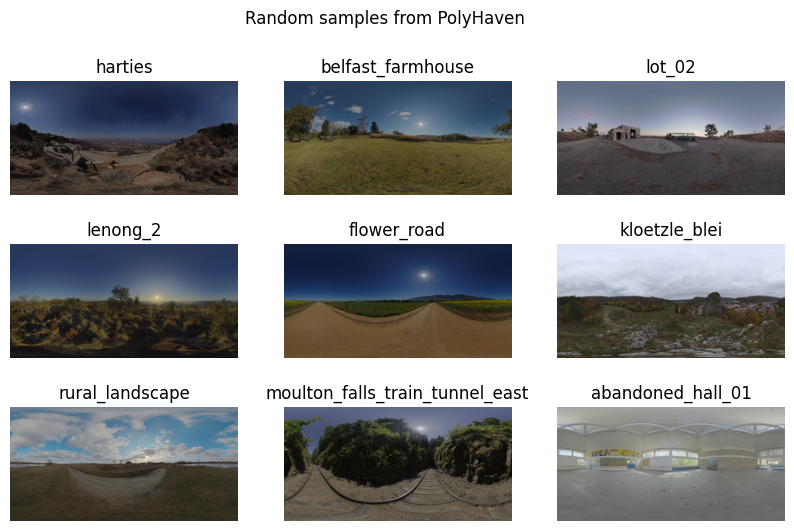

In [60]:
plot_image_batch(x_tensors, title="Random samples from PolyHaven", labels=images_labels)

In [11]:
# Normalize x as intended for input in the VAE
x_norm = transform_normalize(x_tensors)

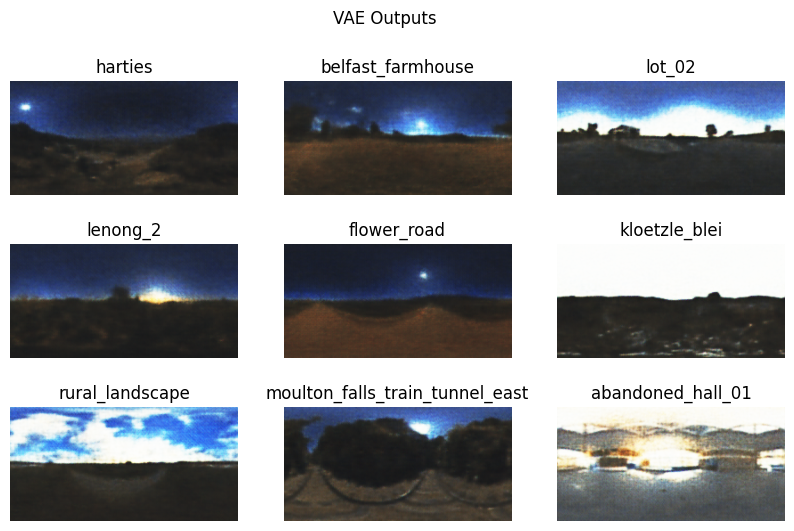

In [51]:
def full_inference(model, input):
    model.eval()
    with torch.no_grad():
            mu, sigma = model.encode(input)
            z = model.reparameterize(mu, sigma)
            output = model.decode(z)
            
    return output

y = full_inference(model, x_norm)

plot_image_batch(y, title="VAE Outputs", labels=images_labels)

# CLIP loss

In [58]:
class CustomCLIPLoss(torch.nn.Module):

    def __init__(self, clip_model="ViT-B/32", checkpoint=None):#, resize=224):
        super(CustomCLIPLoss, self).__init__()
        self.model, clip_preprocess = clip.load(clip_model, device="cuda", jit=False)
        
        if checkpoint is not None:
            # source: https://github.com/openai/CLIP/issues/83
            ckpt = torch.load(checkpoint)
            self.model.load_state_dict(ckpt)
    
        # Remove from the CLIP preprocessor the PIL related operations
        self.preprocess = transforms.Compose([
                clip_preprocess.transforms[0],
                clip_preprocess.transforms[1],
                clip_preprocess.transforms[4]
        ])

        self.preprocess_no_crop = transforms.Compose([
                clip_preprocess.transforms[0],
                clip_preprocess.transforms[4]
        ])

    def forward(self, image, text, crop=True):
        image = self.preprocess(image) if crop else self.preprocess_no_crop(image)
        print (self.model(image, text)[0].shape)
        similarity = 1 - self.model(image, text)[0] / 100
        return similarity

In [59]:
clip_loss = CustomCLIPLoss()

# CLIP optimization

In [17]:
def get_optimizer(var, lr, weight_decay=0):
    var_optim = var.clone().detach().requires_grad_(True)
    optimizer = torch.optim.Adam([var_optim], lr=lr, weight_decay=weight_decay)
    return var_optim, optimizer

## Optimization on plain pixels

In this example, I show that optimizing on plain pixels is not enough: the sparsity nature of the problems makes it impossible for the optimizer to reconstruct what is given in the prompt, resulting in a noisy image

In [71]:
results = torch.zeros(x_tensors.shape)
histories = []

In [72]:
for i, x in enumerate(x_tensors): 
    x = x.unsqueeze(0)
    img_optim, optimizer = get_optimizer(x, lr=1e-3, weight_decay=1e-5)
    prompt = "sunset"
    text = clip.tokenize(prompt).to(device="cuda")

    history={}
    history={'optim_loss':[]}

    loop = tqdm(range(3))

    for it in loop:
        loss_clip = clip_loss(img_optim, text)
        loss = loss_clip
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loop.set_postfix(loss=loss.item())
        history['optim_loss'].append(loss.item())

    results[i] = x.squeeze(0)
    histories.append(history)

 67%|██████▋   | 2/3 [00:00<00:00, 11.66it/s, loss=0.757]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 67%|██████▋   | 2/3 [00:00<00:00, 10.50it/s, loss=0.741]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 67%|██████▋   | 2/3 [00:00<00:00, 11.40it/s, loss=0.744]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 67%|██████▋   | 2/3 [00:00<00:00, 10.99it/s, loss=0.727]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 67%|██████▋   | 2/3 [00:00<00:00, 10.27it/s, loss=0.746]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 33%|███▎      | 1/3 [00:00<00:00,  9.05it/s, loss=0.806]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 33%|███▎      | 1/3 [00:00<00:00,  9.99it/s, loss=0.776]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 67%|██████▋   | 2/3 [00:00<00:00, 11.71it/s, loss=0.743]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


 67%|██████▋   | 2/3 [00:00<00:00, 11.70it/s, loss=0.782]

torch.Size([1, 1])
torch.Size([1, 1])
torch.Size([1, 1])


100%|██████████| 3/3 [00:00<00:00, 11.90it/s, loss=0.753]


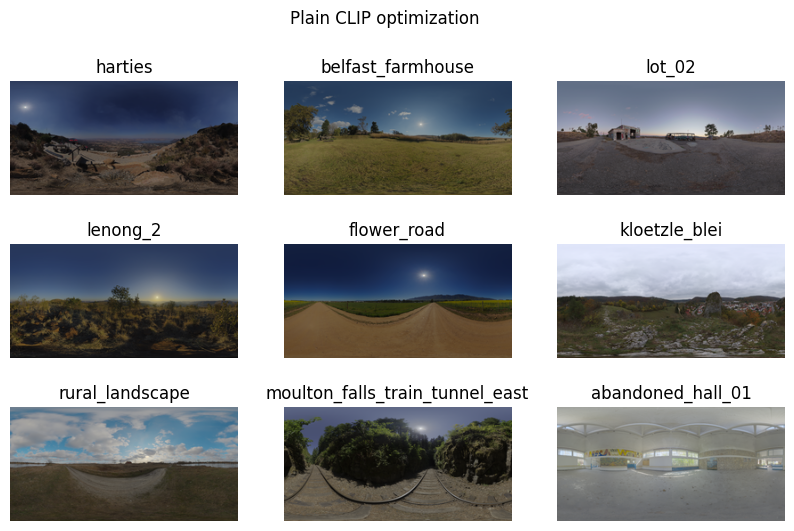

In [54]:
plot_image_batch(results, "Plain CLIP optimization", images_labels)

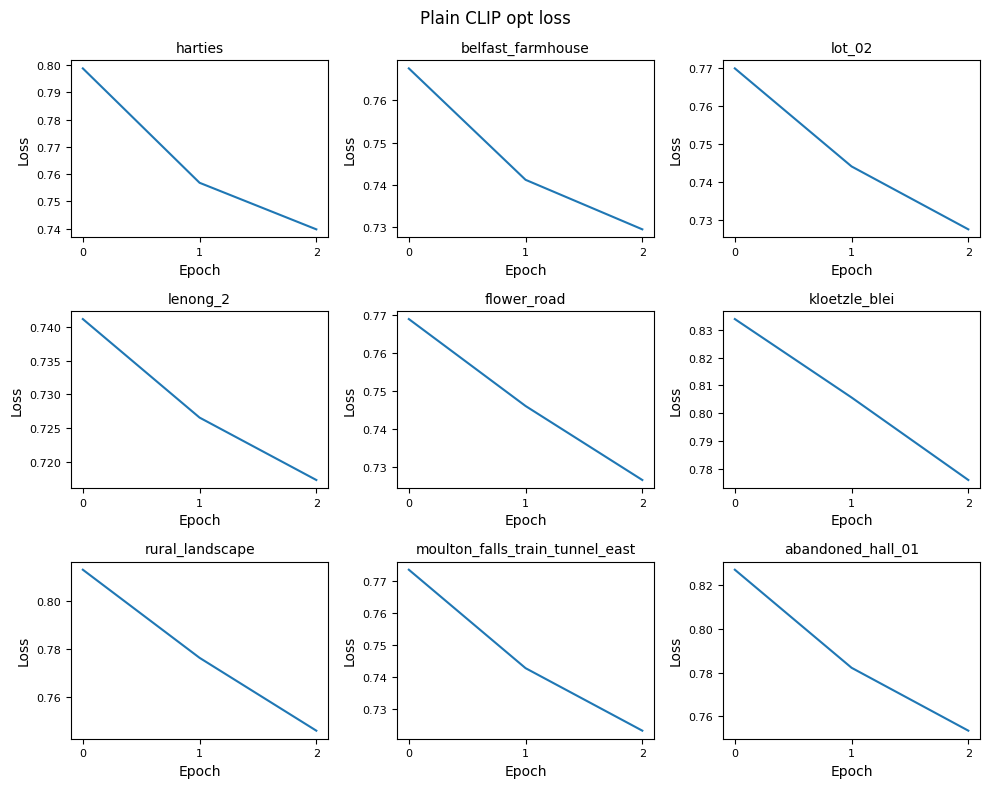

In [88]:
plot_loss_batch(histories, title="Plain CLIP opt loss", labels=images_labels)

# Optimization on latent space: Functions

#### Optimization on z

In [89]:
def decode_z(model, z):
    model.eval()

    mu, sigma = model.get_mu_logvar(z)
    z_rep = model.reparameterize(mu, sigma)
    
    output = model.decode(z_rep)
    return output

#### Optimization on mu, logvar

In [90]:
import torch.nn as nn
class LatentParameters(nn.Module):
    def __init__(self, mu, logvar):
        super(LatentParameters, self).__init__()
        self.mu = nn.Parameter(mu.clone().detach().requires_grad_(True))
        self.logvar = nn.Parameter(logvar.clone().detach().requires_grad_(True))

In [91]:
def decode_mu_logvar(model, mu, sigma):
    model.eval()
    z_rep = model.reparameterize(mu, sigma)
    output = model.decode(z_rep)
    return output

In [92]:
def get_optimizer_distrib(mu, logvar, lr, weight_decay=0):
    parameters = LatentParameters(mu, logvar)
    optimizer = torch.optim.Adam(parameters.parameters(), lr=lr, weight_decay=weight_decay)
    return parameters, optimizer

#### Loss functions

## Optimization on latent space: Ablation Studies

In [97]:
prompt = "sunset"
import torch.nn.functional as F
'''
    optim_type : "fc", "mu_logvar"  
    tv : float
    kl : float
'''

def clip_latent_optimize(input, prompt, vae_model, clip_loss, optim_type="fc", n_iter=1600, tv = 0, kl = 0, lr=0.01, weight_decay=1e-3):

    text = clip.tokenize(prompt).to(device="cuda")
    tv_loss = TotalVariation().to(DEVICE)
    kl_loss = nn.KLDivLoss(reduction="batchmean").to(DEVICE)

    history={}
    history={'optim_loss':[]}

    if optim_type == "fc":
        
        z = model.encode_only(input) 
        z_optim, optimizer = get_optimizer(z, lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

        loop = tqdm(range(n_iter))
        for it in loop:
            tf_img = decode_z(vae_model, z_optim)

            loss_clip = clip_loss(tf_img, text)
            loss_tv = tv * tv_loss(tf_img) if tv>0 else 0

            if kl>0:
                kl_input = F.log_softmax(tf_img)
                kl_target = F.log_softmax(input)
                loss_kl = kl * kl_loss(kl_input, kl_target)

            else:
                loss_kl = 0

            loss = loss_clip + loss_tv + loss_kl

        output = decode_z(vae_model, z_optim)

    elif optim_type == "mu_logvar":
        mu, logvar = model.encode(input)
        parameters_optim, optimizer = get_optimizer_distrib(mu, logvar, lr=lr, weight_decay=weight_decay)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

        loop = tqdm(range(n_iter))
        for it in loop:
            tf_img = decode_mu_logvar(vae_model, parameters_optim.mu, parameters_optim.logvar)

            loss_clip = clip_loss(tf_img, text)
            loss_tv = tv * tv_loss(tf_img) if tv > 0 else 0

            if kl>0:
                kl_input = F.log_softmax(tf_img)
                kl_target = F.log_softmax(input)
                loss_kl = kl * kl_loss(kl_input, kl_target)

            else:
                loss_kl = 0


            loss = loss_clip + loss_tv + loss_kl

        output = decode_mu_logvar(vae_model, parameters_optim.mu, parameters_optim.logvar)

    else: 
        raise ValueError('Accepted optim_type: fc or mu_logvar')
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loop.set_postfix(loss=loss.item(), loss_clip=loss_clip.item(), loss_tv=tv_loss)
    history['optim_loss'].append(loss.item())


    return output, history

#plot_comparison(y, tf_img)
#plot_loss(history)

# Test cases

### Simple prompt

In [98]:
# Reinitialize clip_loss everytime to prevent CUDA out-of-memory
if clip_loss in locals():
    del clip_loss
    torch.cuda.empty_cache()

clip_loss = CustomCLIPLoss(clip_model="ViT-B/32")

# Otimize on z, no regularization

for x in x_norm:
    x = x.unsqueeze(0)
    output, history = clip_latent_optimize(x, prompt, model, clip_loss, n_iter=2,  optim_type="fc", tv = 0, kl = 0, lr=0.01, weight_decay=1e-3)
    results.append({"output": output, "history": history})

output = []
output, history = clip_latent_optimize(input, prompt, model, clip_loss, n_iter=2, optim_type="fc", tv = 1e-6, kl = 0, lr=0.01, weight_decay=1e-3)
results.append({"output": output, "history": history})



output, history =clip_latent_optimize(input, prompt, model, clip_loss, n_iter=2, optim_type="mu_logvar", tv = 0, kl = 0, lr=0.01, weight_decay=1e-3)
results.append({"output": output, "history": history})

100%|██████████| 2/2 [00:00<00:00, 18.43it/s]

torch.Size([1, 1])
torch.Size([1, 1])


AttributeError: 'Tensor' object has no attribute 'append'

### PolyHaven model

In [ ]:
if clip_loss in locals():
    del clip_loss
    torch.cuda.empty_cache()

clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt")

z = model.encode_only(x_norm)
print(z)

z_optim, optimizer = get_optimizer(z, lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

In [ ]:
prompt = "sunset" # environment, sunny, high contrast
text = clip.tokenize(prompt).to(device="cuda")

loop = tqdm(range(1600))

history={}
history={'optim_loss':[]}
for it in loop:
    tf_img = decode_z(model, z_optim)

    loss_clip = clip_loss(tf_img, text)
    tv_loss = tv(tf_img)
    loss = loss_clip
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loop.set_postfix(loss=loss.item())
    history['optim_loss'].append(loss.item())

plot_comparison(y, tf_img)

In [ ]:
plot_loss(history)

### VAE model

In [ ]:
if clip_loss in locals():
    del clip_loss
    torch.cuda.empty_cache()

#clip_loss = CustomCLIPLoss(clip_model="RN50x4", checkpoint="clip_checkpoints/clip_finetuned_polyhaven.pt", resize=288)
clip_loss = CustomCLIPLoss(clip_model="ViT-B/32", checkpoint="clip_checkpoints/clip_finetuned_vae.pt")

z = model.encode_only(x_norm)
print(z)

z_optim, optimizer = get_optimizer(z, lr=0.01, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)

In [ ]:
prompt = "sunset" # environment, sunny, high contrast
text = clip.tokenize(prompt).to(device="cuda")

loop = tqdm(range(1600))

history={}
history={'optim_loss':[]}
for it in loop:
    tf_img = decode_z(model, z_optim)

    loss_clip = clip_loss(tf_img, text)
    tv_loss = tv(tf_img)
    loss = loss_clip
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()
    loop.set_postfix(loss=loss.item())
    history['optim_loss'].append(loss.item())

plot_comparison(y, tf_img)

In [ ]:
plot_loss(history)

## [To-Do] Maybe unnecessary cells

In [ ]:
def decode_mu_logvar(model, mu, sigma):
    model.eval()
    z_rep = model.reparameterize(mu, sigma)
    output = model.decode(z_rep)
    return output

In [ ]:
import torch.nn as nn
class LatentParameters(nn.Module):
    def __init__(self, mu, logvar):
        super(LatentParameters, self).__init__()
        self.mu = nn.Parameter(mu.clone().detach().requires_grad_(True))
        self.logvar = nn.Parameter(logvar.clone().detach().requires_grad_(True))


In [ ]:
def get_optimizer_distrib(mu, logvar, lr, weight_decay=0):
    parameters = LatentParameters(mu, logvar)
    optimizer = torch.optim.Adam(parameters.parameters(), lr=lr, weight_decay=weight_decay)
    return parameters, optimizer

In [ ]:
#z_optim, optimizer = get_optimizer(z, lr=1e-2, weight_decay=1e-3) #1e-3
mu, logvar = model.encode(x_norm)
parameters_optim, optimizer = get_optimizer_distrib(mu, logvar, lr=1e-2, weight_decay=1e-3)#, weight_decay=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=150, gamma=0.5)